# Análisis de datos de aerolíneas del aeropuerto de Santiago de Chile
### Objetivo: 
Analizar el atraso de los vuelos pertenecientes al aeropuerto de Santiago de Chile y calcular el error para los datos de prueba para modelos de machine learning. 
### Problema: 
El problema consiste en predecir la probabilidad de atraso de los vuelos que aterrizan o despegan del aeropuerto de Santiago de Chile (SCL). Para eso les entregamos un dataset usando datos públicos y reales donde cada fila corresponde a un vuelo que aterrizó o despegó de SCL.
Generar las columnas adicionales y luego expórtelas en un archivo synthetic_features.csv :
temporada_alta : 1 si Fecha-I está entre 15-Dic y 3-Mar, o 15-Jul y 31-Jul, o 11-Sep y 30-Sep, 0 si no.\
dif_min: diferencia en minutos entre Fecha-O y Fecha-I. \
atraso_15: 1 si dif_min > 15, 0 si no. \
periodo_dia: mañana (entre 5:00 y 11:59), tarde (entre 12:00 y 18:59) y noche (entre 19:00 y 4:59), en
base a Fecha-I. 
Graficar y mostrar la mayor tasa de atraso para cada caso. \
Entrenar modelos de machine learning y evaluar el rendimiento.

### ¿Cómo lo solucionaste? o ¿Por qué no existe una solución? 

El problema se solucionó a partir de que se crearon las variables sintéticas por medio de funciones, para luego hacer los gráficos correspondientes de los atrasos en los vuelos, y una vez hecho esto, crear un archivo *.csv* con las variables sintéticas y exportarlo. Debido a que los modelos de Random Forest y Logistic Regression usados a partir de las librerías *from sklearn.ensemble import RandomForestClassifier* y *from sklearn.model_selection import train_test_split* no soportan variables que no sean del tipo numéricas, se pasaron todas las variables de entrenamiento a *dummy*. Se entrenaron los modelos de machine learning Random Forest y Logistic Regression, y por medio del criterio de error accuracy, se evaluó el rendimiento de ambos modelos. 



### Descripción de las variables:

Dentro del archivo .csv, los encabezados con los datos son los siguientes:

Fecha-I : Fecha y hora programada del vuelo.\
Vlo-I : Número de vuelo programado.\
Ori-I : Código de ciudad de origen programado.\
Des-I : Código de ciudad de destino programado.\
Emp-I : Código aerolínea de vuelo programado.\
Fecha-O : Fecha y hora de operación del vuelo.\
Vlo-O : Número de vuelo de operación del vuelo.\
Ori-O : Código de ciudad de origen de operación\
Des-O : Código de ciudad de destino de operación.\
Emp-O : Código aerolínea de vuelo operado.\
DIA : Día del mes de operación del vuelo.\
MES : Número de mes de operación del vuelo.\
AÑO : Año de operación del vuelo.\
DIANOM : Día de la semana de operación del vuelo.\
TIPOVUELO : Tipo de vuelo, I =Internacional, N =Nacional.\
OPERA : Nombre de aerolínea que opera.\
SIGLAORI : Nombre ciudad origen.\
SIGLADES : Nombre ciudad destino.\


In [62]:
#Importar librerías
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [63]:
#Ajustar parametros para cargar DataFrame 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [64]:
#Carga archivo .csv como DataFrame
parse_dates=['Fecha-I','Fecha-O']
df=pd.read_csv('dataset_SCL.csv', parse_dates=parse_dates, low_memory= False)
print(df.dtypes)
print(df.shape)

Fecha-I      datetime64[ns]
Vlo-I                object
Ori-I                object
Des-I                object
Emp-I                object
Fecha-O      datetime64[ns]
Vlo-O                object
Ori-O                object
Des-O                object
Emp-O                object
DIA                   int64
MES                   int64
AÑO                   int64
DIANOM               object
TIPOVUELO            object
OPERA                object
SIGLAORI             object
SIGLADES             object
dtype: object
(68206, 18)


### Solución al problema: Se crea la clase *Build_vuelos* con distintos métodos en su interior, cada método contiene su respectiva descripción. Por medio de estos métodos es que se crean las variables sintéticas, se elaboran los gráficos, se entrenan los modelos de machine learning y se crea el archivo *.csv* para luego exportarlo

In [65]:
class Build_vuelos:
    def __init__(self, df : pd.DataFrame) -> None:
        self.df=df
    
    def fil(self, var : str, month : int, day_from : int, day_to : int) -> pd.Series:
        """
            Seleccionar desde el día `day_from` del mes `month` hasta la día `day_to`
            
        Parameters
        ----------
        var : str 
            Nombre de la variable a filtrar.
        month : int
            Mes del año.
        day_from : int
            Día donde inicia el intervalo.
        day_to : int
            Día donde termina el intervalo.
                    
        Returns
        -------
        pd.Series  
            Series de boolean.
        """
        return (self.df[var].dt.month.eq(month)&self.df[var].dt.day.between(day_from,day_to))*True
    
    def to_date_type(self, var1: str, var2: str) -> np.timedelta64:
        """
           Selecciona las columnas Fecha-O y Fecha-I; fecha de operación y fecha de inicio del viaje respectivamente.
           Convierte de timedelta64[ns] (nanosegundos) a timedelta64[m] (minutos).

        Parameters
        ----------
        var1 : str
            Nombre de la variable a filtrar.
        var2 : str
            Nombre de la variable a filtrar.

        Returns
        -------
            np.timedelta64[m] 
                Diferencia de 'Fecha-I' y 'Fecha-O' mostrada en minutos.

        """
        return (pd.DataFrame(self.df[var1]-self.df[var2]).astype('timedelta64[m]')) #var1: 'Fecha-O', var2: 'Fecha-I'
    
    def vuelo_atrasado(self, threshold: int) -> pd.DataFrame:
        """
        Crea una columna de datos a partir del método to_date_type; si la diferencia entre 'Fecha-O' (fecha de operación del vuelo) 
        y'Fecha-I' (fecha de inicio del vuelo) superior a 15 minutos (valor umbral), se considera que el vuelo presenta atraso. Luego
        inserta la nueva columna al DataFrame.

        Parameters
        ----------
        threshold : int
            Umbral de tiempo (en minutos) para que un vuelo se considere con atraso.

        Returns
        -------
        pd.DataFrame
            Nuevo DataFrame que se inserta como columna a los datos originales.

        """
        atraso_15=(self.to_date_type('Fecha-O','Fecha-I') > threshold).astype(int) #threshold = 15
        return self.df.insert(18,'Atraso', atraso_15,True)  
    
    def periodo_dia_vuelo(self, var1 : str , hora1 : str, hora2 : str, var2: str) -> pd.DataFrame:
        """
        Según la fecha de inicio del vuelo (Fecha-I), Se clasifica si el vuelo se realiza en la mañana, tarde o noche.

        Parameters
        ----------
        var1 : str
            Nombre de la variable a filtrar.
        hora1 : str
            Hora donde inicia el intervalo.
        hora2 : str
            Hora donde termina el intervalo.
        var2 : str
            En caso de cumplir la condución dentro del np.where, entonces var2.

        Returns
        -------
        pd.DataFrame
            DataFrame con la descripción del vuelo si fue hecho en la mañana, tarde o noche.

        """
        
        return pd.DataFrame(np.where((df[var1]).dt.strftime('%H:%M:%S').between(hora1,hora2), var2, ''))
    
    def bar_plot_vuelos(self, var1: str, var2: str, plot_type: str, plot_title: str, y_label: str, x_label: str, m : int, n : int) -> pd.DataFrame.plot :
        """
        Retorna gráficos de barra y el resultado con el mayor valor.

        Parameters
        ----------
        var1 : str
            Nombre de la variable a filtrar.
        var2 : str
            Nombre de la variable a filtrar.
        plot_type : str
            Tipo de gráfico.
        plot_title : str
            Título del gráfico.
        y_label : str
            Nombre del eje Y.
        x_label : str
            Nombre del eje X.
        m : int
            Ajusta tamaño del gráfico.
        n : int
            Ajusta tamaño del gráfico.

        Returns
        -------
        bar_plot : pd.DataFrame.plot
            Gráfico.
        text_result : str
            Muestra el mayor valor.

        """
        datos=self.df[var2].describe()
        Total_datos=datos.max()
        df_groups=self.df.groupby(var1)[var2].sum()
        plt.figure()
        df_groups.plot(kind=plot_type)
        bar_plot=df_groups.plot(kind=plot_type, title=plot_title ,ylabel=y_label, xlabel=x_label, figsize=(m,n))
        Porcentaje_atrasos_destino=(df_groups.max())/(Total_datos)*100
        text_result=f"{df_groups.idxmax()} tiene el mayor porcentaje de atrasos: {Porcentaje_atrasos_destino:.3}%"
        # print( df_groups.idxmax() + ' tiene el mayor porcentaje de atrasos: ' +str( round(Porcentaje_atrasos_destino,2)) + '%')
        return bar_plot,text_result
    
    def test_train_split_data(self) -> pd.DataFrame :
        """
        Retorna X_train,X_test,y_train,y_test. Se usó 'get_dummies' para pasar las variables seleccionadas a numéricas.

        Returns
        -------
        X_train : pd.DataFrame
            Datos de entrenamiento.
        X_test : pd.DataFrame
            Datos de prueba.
        y_train : pd.Series
            Etiquetas para los datos de entrenamiento.
        y_test : pd.Series
            Etiquetas para los datos de prueba.
        
        """
        Y=df.iloc[:,18]
        x=df.iloc[:,df.columns !='Atraso']
        x=x.drop(columns=['Fecha-I', 'Fecha-O'])
        x_aux=pd.get_dummies(x.loc[:,["Vlo-I","Des-I","Emp-I",'Vlo-O','Ori-O','Ori-I','Des-O','Emp-O','DIANOM','TIPOVUELO','OPERA','SIGLAORI','SIGLADES']])
        result = pd.concat([x, x_aux], axis=1)
        result=result.drop(columns=["Vlo-I","Des-I","Emp-I",'Vlo-O','Ori-O','Ori-I','Des-O','Emp-O','DIANOM','TIPOVUELO','OPERA','SIGLAORI','SIGLADES'])
        x=result
        X_train,X_test,y_train,y_test= train_test_split(x,Y, test_size=0.2, random_state=np.random)
        return X_train,X_test,y_train,y_test
    
    def RF_classifier(self , n_1: int, n_2: int, n_3: int) -> str :
        """
        Entrena Random Forest y luego da el error para los datos de test.

        Parameters
        ----------
        n_1 : int
            Hiperparámetro de ajuste.
        n_2 : int
            Hiperparámetro de ajuste.
        n_3 : int
            Hiperparámetro de ajuste.

        Returns
        -------
        str
            Devuelve el error de prueba para Random Forest como porcentaje.

        """
        RF = RandomForestClassifier(n_estimators=n_1, max_depth=n_2, random_state=n_3)
        X_train,X_test,y_train,y_test=self.test_train_split_data()
        RF.fit(X_train, y_train)
        errorPruebaRF=(1-RF.score(X_test,y_test))*100
        return f"El error de prueba de Random Forest es: {errorPruebaRF:.3}%"
    
    def LR_classifier(self, n_1: int , n_2: int , s_1: str, s_2: str) -> str :
        """
        Entrena Logistic Regression y luego da el error para los datos de test

        Parameters
        ----------
        n_1 : int
            Hiperparámetro de ajuste.
        n_2 : int
            Hiperparámetro de ajuste.
        s_1 : str
            Argumento para un solucionador que permita la regresión logística multinomial.
        s_2 : str
            Configuración para regresión logística multinomial.

        Returns
        -------
        str
            Devuelve el error de prueba para Random Forest como porcentaje.

        """
        X_train,X_test,y_train,y_test=self.test_train_split_data()
        LR=LogisticRegression(random_state=n_1, solver=s_1, multi_class=s_2, max_iter=n_2).fit(X_train, y_train)
        errorPruebaLR=100*(1-LR.score(X_test,y_test)) 
        return f"El error de prueba de Logistic Regresion es: {errorPruebaLR:.3}%"
    
    def Excel_synthetic_features(self, var1: str , var2 : str, var3: str , var4: str) -> pd.DataFrame.to_csv:
        """
        Genera un Excel con las variables sintéticas que se crearon (las que se crearon con código y no aparecen explícitamente en dataset_SCL.csv)

        Parameters
        ----------
        var1 : str
            Nombre de la variable a agregar al nuevo DataFrame.
        var2 : str
            Nombre de la variable a agregar al nuevo DataFrame.
        var3 : str
            Nombre de la variable a agregar al nuevo DataFrame.
        var4 : str
            Nombre de la variable a agregar al nuevo DataFrame.

        Returns
        -------
        pd.DataFrame.to_csv
            Genera un archivo .csv con las nuevas variables creadas.

        """
        df_new_features=pd.DataFrame()
        df_new_features[var1]=temporada_alta
        df_new_features[var2]=self.to_date_type('Fecha-O','Fecha-I')
        df_new_features[var3]=self.df[var3]
        df_new_features[var4]=pd.DataFrame(ia.periodo_dia_vuelo('Fecha-I','05:00:00','11:59:00','mañana')+ ia.periodo_dia_vuelo('Fecha-I','12:00:00','18:59:00','tarde')+
                                       ia.periodo_dia_vuelo('Fecha-I','19:00:00','23:59:00','noche')+ ia.periodo_dia_vuelo('Fecha-I','00:00:00','04:59:00','noche'))
        return df_new_features.to_csv('synthetic_features.csv')

In [66]:
#Obtención de pd.DataFrame temporada_alta
ia = Build_vuelos(df) # instancia_temporada_alta
temporada_alta=pd.DataFrame( pd.DataFrame(ia.fil("Fecha-I",12,15,31)|ia.fil("Fecha-I",3,1,3))|pd.DataFrame(ia.fil("Fecha-I",7,15,31))|pd.DataFrame(ia.fil("Fecha-I",9,11,30))).astype(int)

In [67]:
#Obtención de pd.DataFrame horario de vuelos
cambio_tipo=ia.to_date_type('Fecha-O','Fecha-I')
atraso_vuelos=ia.vuelo_atrasado(15)
vuelos=pd.DataFrame(ia.periodo_dia_vuelo('Fecha-I','05:00:00','11:59:00','mañana')+ ia.periodo_dia_vuelo('Fecha-I','12:00:00','18:59:00','tarde')+
                    ia.periodo_dia_vuelo('Fecha-I','19:00:00','23:59:00','noche')+ ia.periodo_dia_vuelo('Fecha-I','00:00:00','04:59:00','noche'))

'Buenos Aires tiene el mayor porcentaje de atrasos: 2.38%'

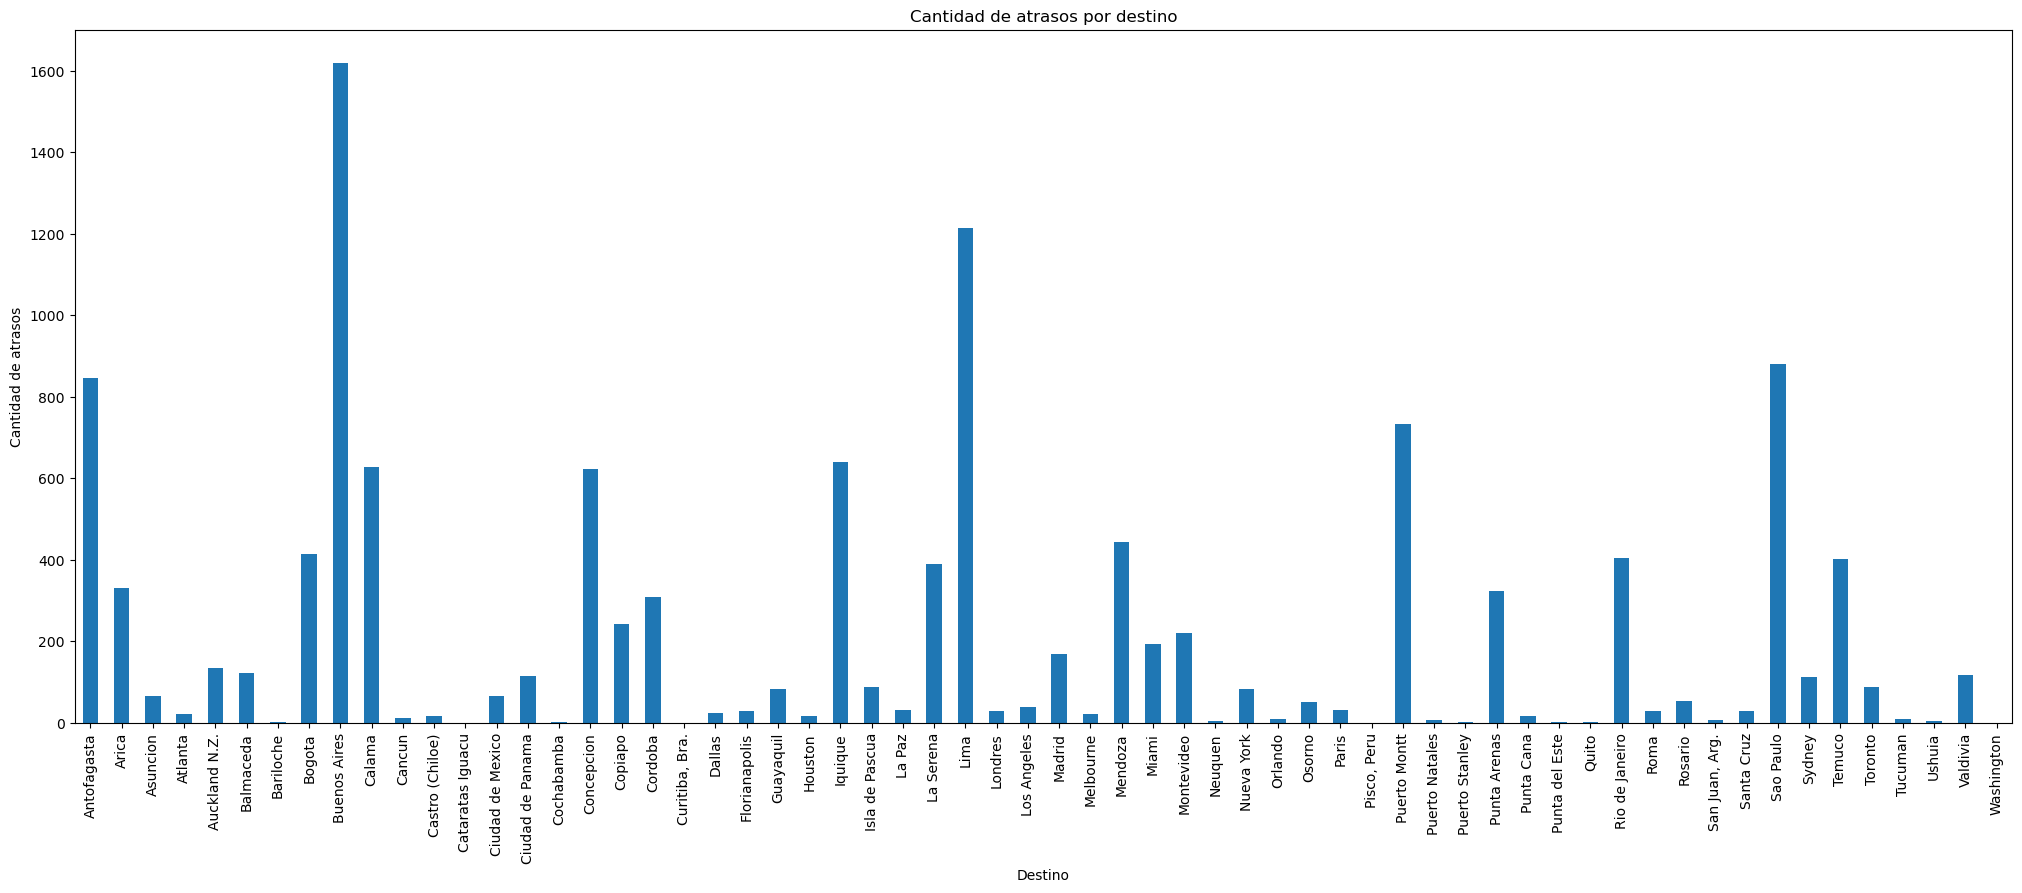

In [68]:
#Gráficos 1
plot1, text_result1=ia.bar_plot_vuelos('SIGLADES', 'Atraso', 'bar', 'Cantidad de atrasos por destino', 'Cantidad de atrasos', 'Destino', 25,9)
text_result1

'Grupo LATAM tiene el mayor porcentaje de atrasos: 10.7%'

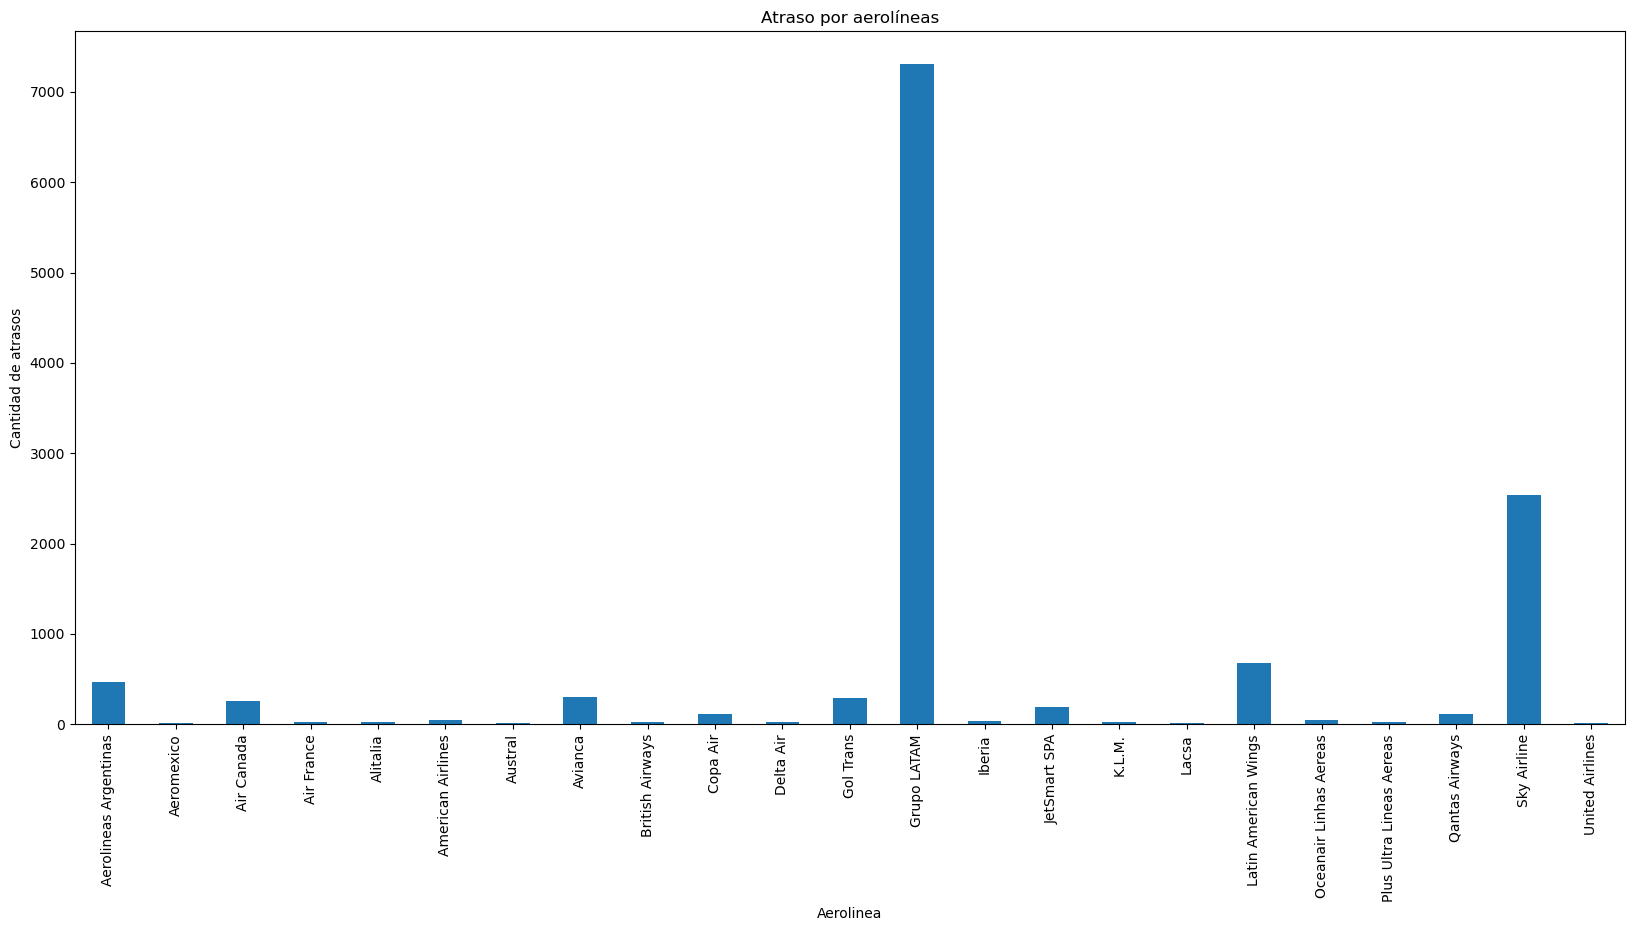

In [69]:
#Gráficos 2
plot2, text_result2=ia.bar_plot_vuelos('OPERA', 'Atraso', 'bar', 'Atraso por aerolíneas', 'Cantidad de atrasos', 'Aerolinea',20,9)
text_result2

'7 tiene el mayor porcentaje de atrasos: 2.58%'

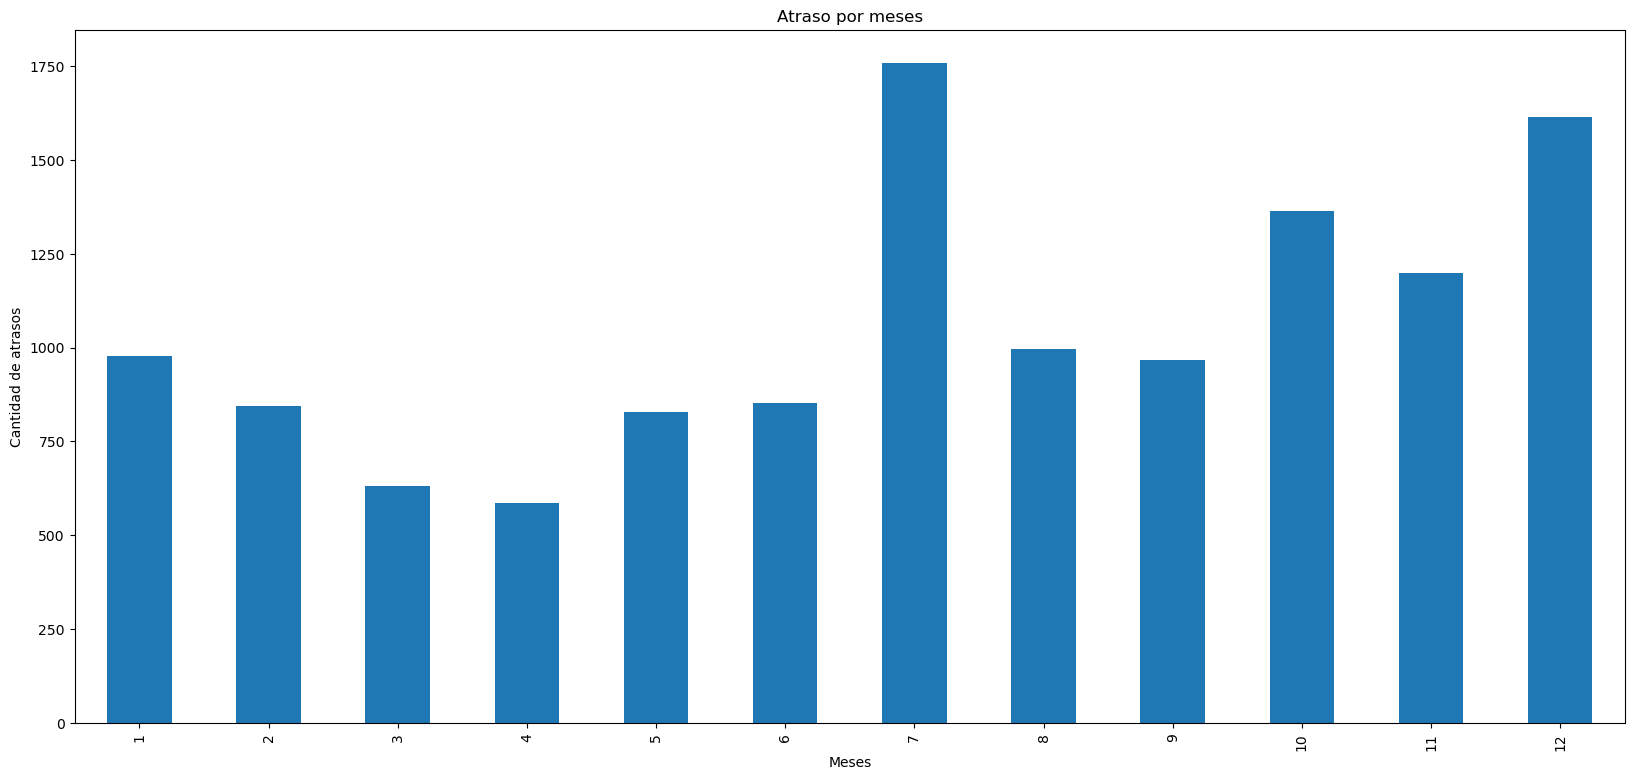

In [70]:
#Gráficos 3. Los meses están ordenados numéricamente.
plot3, text_result3=ia.bar_plot_vuelos('MES', 'Atraso', 'bar', 'Atraso por meses', 'Cantidad de atrasos', 'Meses', 20,9)
text_result3

'Viernes tiene el mayor porcentaje de atrasos: 3.35%'

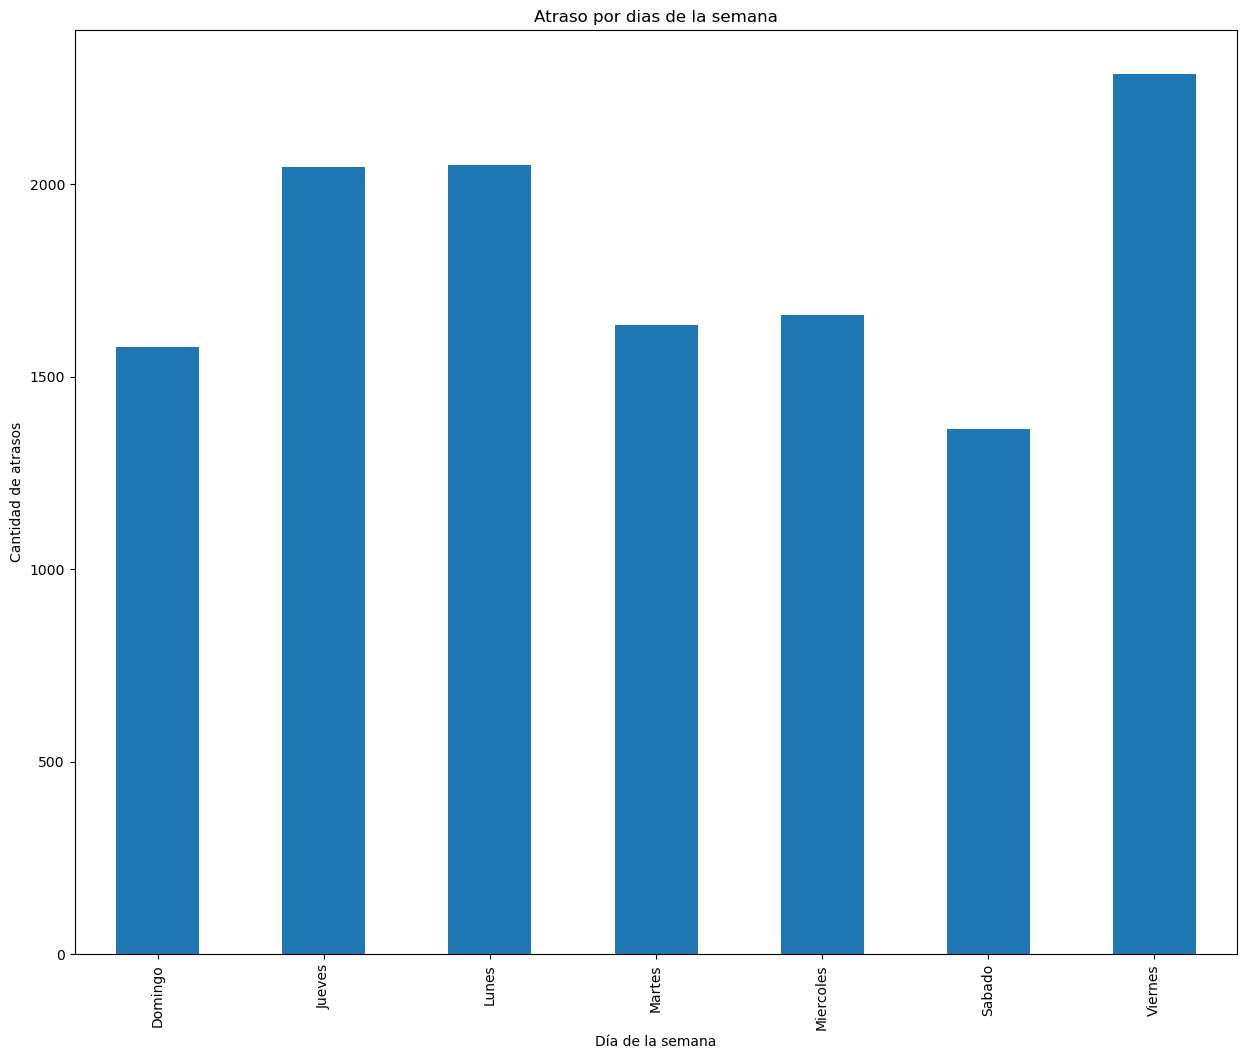

In [71]:
#Gráficos 4
plot4, text_result4=ia.bar_plot_vuelos('DIANOM', 'Atraso', 'bar', 'Atraso por dias de la semana', 'Cantidad de atrasos', 'Día de la semana',15,12)
text_result4

'I tiene el mayor porcentaje de atrasos: 10.3%'

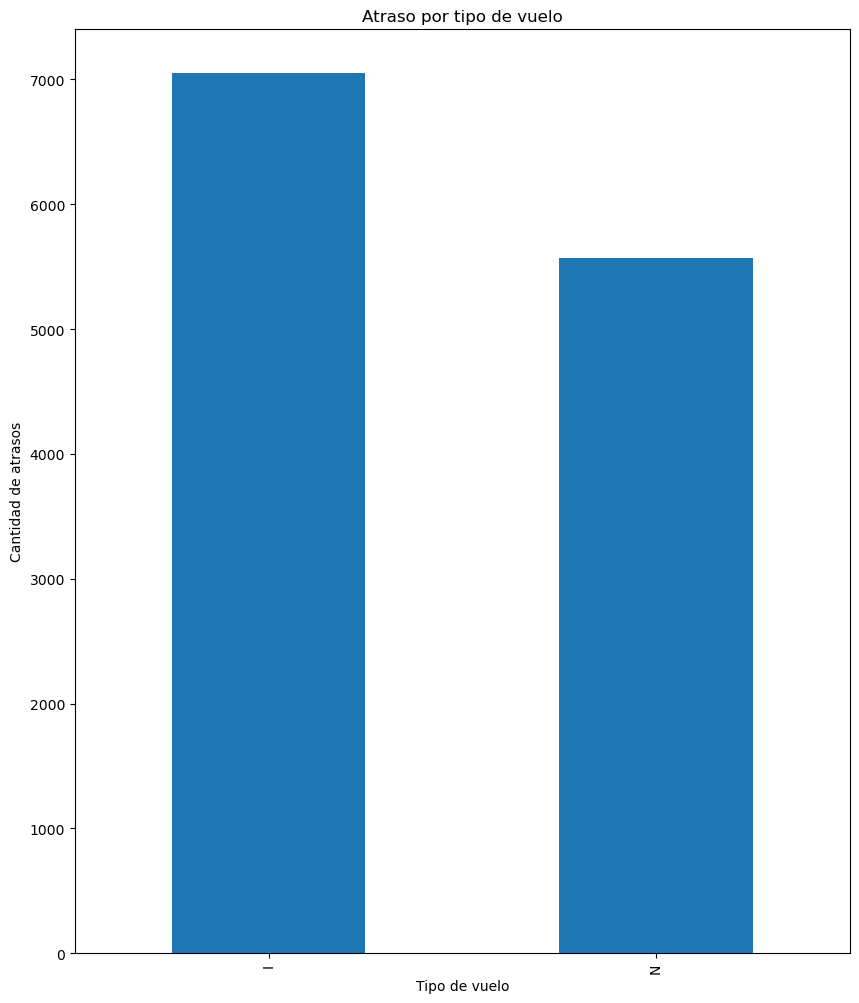

In [72]:
#Gráficos 5. I: Vuelos internacionales, N: Vuelos nacionales.
plot5, text_result5=ia.bar_plot_vuelos('TIPOVUELO', 'Atraso', 'bar', 'Atraso por tipo de vuelo', 'Cantidad de atrasos', 'Tipo de vuelo',10,12)
text_result5

'0 tiene el mayor porcentaje de atrasos: 14.6%'

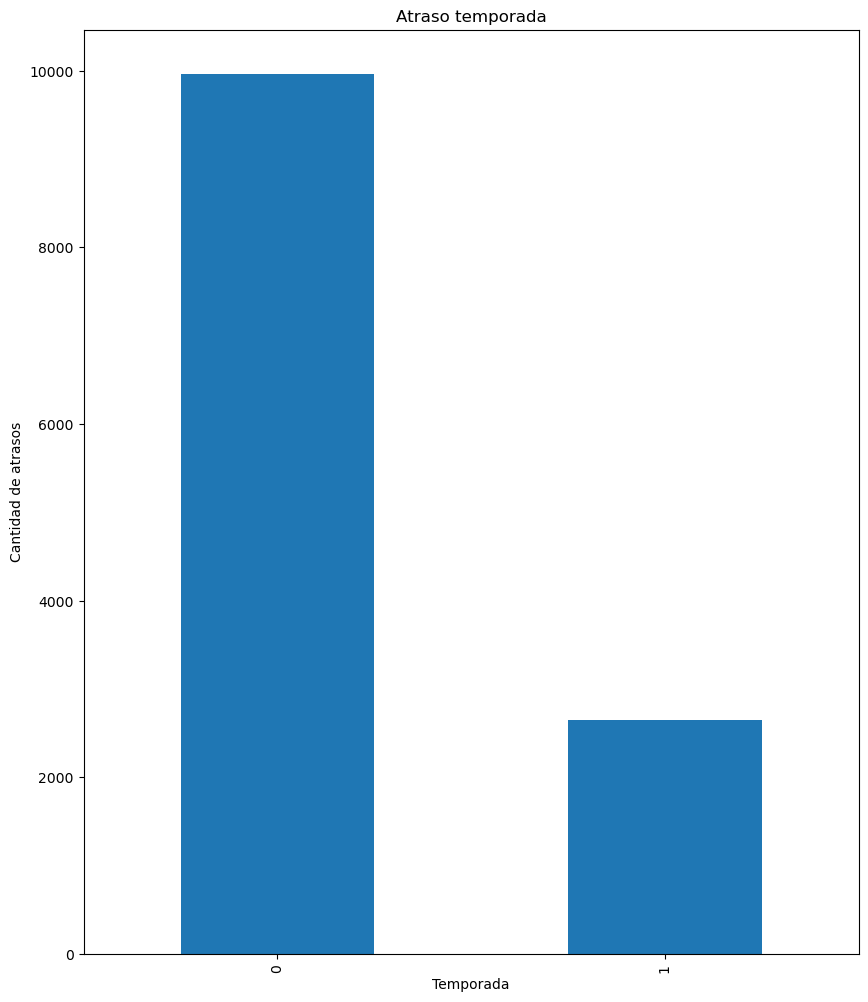

In [73]:
#Gráficos 6. 0: No es dato de temporada alta. 1: Es dato de temporada alta
plot6, text_result6=ia.bar_plot_vuelos(temporada_alta['Fecha-I'], 'Atraso', 'bar', 'Atraso temporada', 'Cantidad de atrasos', 'Temporada',10,12)
text_result6

In [74]:
#ver datos entrenamiento y test
# X_train,X_test,y_train,y_test=ia.test_train_split_data()

In [75]:
#Entrenamiento y test de Random Forest y Logistic Regression
rf=ia.RF_classifier(100,20,0)
rf

'El error de prueba de Random Forest es: 18.0%'

In [76]:
lr=ia.LR_classifier(0,1000,"lbfgs","ovr")
lr

'El error de prueba de Logistic Regresion es: 18.0%'

In [77]:
#Genera archivo Excel con las synthetic features
Excel_synthetic=ia.Excel_synthetic_features('temporada_alta','Diferencia Minutos','Atraso','Periodo dia')